In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

import keras 
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils
import keras.backend as k
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['fer2013for-recognition', 'facial-expression']


In [2]:
filename = '../input/facial-expression/fer2013/fer2013.csv'

def read_data(filename):
    
    X = []
    Y = []
    first = True
    for line in open(filename):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])
        
    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [3]:
X, Y = read_data(filename)
num_class = len(set(Y))
print(num_class)

7


In [4]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=101)
y_train = np_utils.to_categorical(y_train, 7)
y_test = np_utils.to_categorical(y_test, 7)

In [6]:
num_features = 64
width, height = 48, 48
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_class, activation='softmax'))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)       512       
__________

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint('../input/model.h5', monitor='val_loss', verbose=1, save_best_only=True)

callbacks = [lr_reducer, early_stopper, checkpointer]

In [9]:
# With Augmentation
bs = 64
epochs = 100

aug = ImageDataGenerator(rotation_range=20, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

H = model.fit_generator(aug.flow(x_train, y_train, batch_size=bs),
                        validation_data=(x_test, y_test), 
                        steps_per_epoch=len(x_train)//bs,
                        callbacks=callbacks,
                        shuffle=True,
                        epochs=epochs)

Epoch 1/100
448/448 [==============================] - 21s 47ms/step - loss: 2.0083 - acc: 0.2118 - val_loss: 1.8324 - val_acc: 0.2506

Epoch 00001: val_loss improved from inf to 1.83238, saving model to ../input/model.h5
Epoch 2/100
448/448 [==============================] - 17s 37ms/step - loss: 1.8326 - acc: 0.2441 - val_loss: 1.8107 - val_acc: 0.2523

Epoch 00002: val_loss improved from 1.83238 to 1.81070, saving model to ../input/model.h5
Epoch 3/100
448/448 [==============================] - 17s 37ms/step - loss: 1.8158 - acc: 0.2497 - val_loss: 1.8262 - val_acc: 0.2523

Epoch 00003: val_loss did not improve from 1.81070
Epoch 4/100
448/448 [==============================] - 16s 37ms/step - loss: 1.8013 - acc: 0.2551 - val_loss: 1.8383 - val_acc: 0.2524

Epoch 00004: val_loss did not improve from 1.81070
Epoch 5/100
448/448 [==============================] - 17s 37ms/step - loss: 1.7678 - acc: 0.2757 - val_loss: 1.7078 - val_acc: 0.2972

Epoch 00005: val_loss improved from 1.8107

In [10]:
scores = model.evaluate(x_test, y_test, batch_size=bs)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

7178/7178 [==============================] - 1s 174us/step
Loss: 0.9379754525168954
Accuracy: 0.6540819169851225


/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


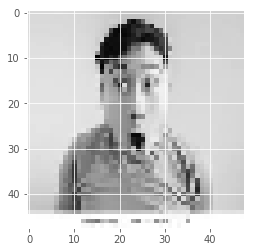

[0.06688503 0.00928699 0.25283882 0.06200942 0.09636712 0.3951489
 0.11746369]


In [12]:
img = image.load_img('../input/fer2013for-recognition/index.jpeg', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255
custom = model.predict(x)

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
print(custom[0])

In [13]:
custom = custom[0]
emotion = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
#Find the maximum probablity of a image and select that class
lar = 0
for i, ele in enumerate(custom):
    if ele > lar:
        msg = emotion[i]
        lar = ele 
    else:
         pass
print(msg)

surprise
